In [182]:
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from scipy.interpolate import interp1d
import scipy.io

# sionna imports
from sionna.constants import PI
from sionna.rt.antenna import polarization_model_2, polarization_model_1
from sionna.rt.antenna import Antenna, visualize

Define our `msi_reader` function

In [183]:
def msi_file_reader(msi_path):
    """
    This function reads the most relevant information out of an .msi file
    to further reconstruct the 3D radiation pattern of a given antenna

    Input:
    - msi_path (str) --> A sting containing the path to the .msi file

    Otuputs:
    - horizontal_gains (tf.constant)
    - vertical_gains (tf.constant)
    - antenna_gain (float)
    """

    # Initialize lists to hold the angles and gains for horizontal and vertical patterns
    horizontal_angles = []
    horizontal_gains = []
    vertical_angles = []
    vertical_gains = []

    # Parse the .msi file
    with open(msi_path, 'r') as file:

        # let us firstly extract the gain of the antenna
        for line in file: # let us firstly search for the antenna gain
            # Use regex to match the 'GAIN' keyword and extract the value
            match = re.search(r"GAIN\s+([\d.]+)\s*dBd", line, re.IGNORECASE)
            if match:
                antenna_gain = float(match.group(1))
                antenna_gain = antenna_gain + 2.15 # turn dBds into dBis
                break
            else:
                print(f'No antenna GAIN detected !!')
        
        lines = file.readlines()
        horizontal_section = False
        vertical_section = False
        for line in lines:
            # Identify sections
            if "HORIZONTAL" in line:
                horizontal_section = True
                vertical_section = False
                continue
            elif "VERTICAL" in line:
                vertical_section = True
                horizontal_section = False
                continue

            # Parse angles and gains
            if horizontal_section:
                angle, gain = map(float, line.strip().split())
                horizontal_angles.append(np.radians(angle))
                horizontal_gains.append(gain)
            elif vertical_section:
                angle, gain = map(float, line.strip().split())
                # if angle < 180:  # Only process angles less than or equal to 180 degrees
                vertical_angles.append(np.radians(angle))
                vertical_gains.append(gain)

    # test if vertical gains and vertical angles have the same shape or not 
    if len(vertical_angles) == len(vertical_gains):
        print(f"Both lists (ANGLES & GAINS) on the VERTICAL plane have the same length")

    # repeat for the horizontal plane
    if len(horizontal_angles) == len(horizontal_gains):
        print(f"Both lists (ANGLES & GAINS) on the HORIZONTAL plane have the same length")

    # Convert horizontal angles to a NumPy array and adjust range to [-pi, pi]
    horizontal_angles = np.array(horizontal_angles) 
    horizontal_gains = np.array(horizontal_gains)

    # Convert vertical angles to a NumPy array and adjust range to [0, pi]
    vertical_angles = np.array(vertical_angles) 
    vertical_angles = np.append(vertical_angles[0:91],vertical_angles[270:360])

    vertical_gains = np.array(vertical_gains)
    vertical_gains = np.append(vertical_gains[0:91],vertical_gains[270:360])

    return antenna_gain, horizontal_angles, horizontal_gains, vertical_angles, vertical_gains

Define our custom pattern and our reconstruction algorithm. In this case we have implemented the cross-weighted algorithm

In [184]:
def cross_weighted_algorithm(horizontal_angles,horizontal_gains,vertical_angles,vertical_gains):
    '''
    This function takes as input both horizontal and vertical converted
    angles as well as their associated gains. The aim is to reconstruct in
    3D the radiation pattern, given its .msi file.
    The function outputs the antenna gain on both angles.

    Inputs:
    - antenna_gain (float) -> The gain of the antenna, read from the .msi file
    - horizontal_gains (tf.constant) -> A file containing the gains from the
        horizontal plane of the antenna.
    - vertical_gains (tf.constant) -> A file containing the gains from the
        vertical plane of the antenna.

    Outputs:
    - G_w_theta_phi () -> Final gains of the interpolated radiation pattern
    '''

    # Initialize a matrix for storing gain values
    G_w_theta_phi = np.zeros((len(horizontal_angles), len(vertical_angles)))

    k = 2 # this is the normalization parameter, k=2 yields the best results
    for i, _ in enumerate(horizontal_angles):
        for j, _ in enumerate(vertical_angles):

            # compute linear gains for the weights computation
            horizontal_linear_gain = 10**(horizontal_gains[i]/10)
            vertical_linear_gain = 10**(vertical_gains[j]/10)

            # compute weights
            w1_i_j = vertical_linear_gain*(1-horizontal_linear_gain)
            if w1_i_j < 0:
                print(f"The weigh w1_i_j is NEGATIVE, SOLVE IT: {w1_i_j}")
            elif w1_i_j == 0:
                print(f"The weigh w1_i_j is NULL, SOLVE IT: {w1_i_j}")
                epsilon = 1e-12
                w1_i_j += epsilon
            w2_i_j = horizontal_linear_gain*(1-vertical_linear_gain)
            if w2_i_j < 0:
                print(f"The weigh w2_i_j is NEGATIVE, SOLVE IT: {w2_i_j}")
            elif w2_i_j == 0:
                print(f"The weigh w2_i_j is NULL, SOLVE IT: {w2_i_j}")
                epsilon = 1e-12
                w2_i_j += epsilon

            # debugging the code
            denom = (w1_i_j**k + w2_i_j**k)**(1/k)
            A1 = w1_i_j/denom
            A2 = w2_i_j/denom

            summing_weights = A1**k + A2**k
            print(f"Este es el summing results: {summing_weights}")
            # assert summing_weights == 1, f'The sum of weights is not equal to 1: {summing_weights}'
            G_w_theta_phi[i,j] = horizontal_gains[i]*A1 + vertical_gains[j]*A2
    
    weighted_antenna_gains = 3.1 + G_w_theta_phi # let's extract the isotropic gain from the antenna
    weighted_antenna_gains = 10**(weighted_antenna_gains/10) # let's take results to a linear domain

    return weighted_antenna_gains


# Custom antenna pattern function to be used in Sionna
def antenna_3D_rad_pattern(weighted_antenna_gains):
    """
    This function takes the weighted antenna gains computed with the help
    of the cross-weighted algorithm, and represents the gains in a 3D plot
    to illustrate the radiation pattern given by the original data retrieved
    from the .msi file
    """

    # Create a mesh grid for azimuth and elevation angles
    theta = np.linspace(0.0, np.pi, 181)
    theta = np.flip(theta)
    theta = np.roll(theta,90)

    phi = np.linspace(0, 2*np.pi, 360)
    theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')
    theta_grid = np.transpose(theta_grid)
    phi_grid = np.transpose(phi_grid)

    # g = np.transpose(10**(MATLAB_3D_pattern/10))
    g = weighted_antenna_gains
    
    print("This is the shape of the cross-weighted gain: ", {np.shape(g)})
    print(f"This is the type of the cross-weighted gain: {type(g)}")

    x = g * np.sin(theta_grid) * np.cos(phi_grid)
    y = g * np.sin(theta_grid) * np.sin(phi_grid)
    z = g * np.cos(theta_grid)
     
    # g = np.maximum(g, 1e-6)
    g_db = 10*np.log10(g)
    # g_db = g
     
    def norm(x, x_max, x_min):
        """Maps input to [0,1] range"""
        x = 10**(x/10)
        x_max = 10**(x_max/10)
        x_min = 10**(x_min/10)
        if x_min==x_max:
            x = np.ones_like(x)
        else:
            x -= x_min
            x /= np.abs(x_max-x_min)
        return x

    g_db_min = np.min(g_db)
    g_db_max = np.max(g_db)
     
    fig_3d = plt.figure()
    ax = fig_3d.add_subplot(1,1,1, projection='3d')
    ax.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=0,
                    antialiased=False, alpha=0.7,
                    facecolors=cm.turbo(norm(g_db, g_db_max, g_db_min)))
    # plt.xlim([-1, 1]) 
     
    sm = cm.ScalarMappable(cmap=plt.cm.turbo)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation="vertical", location="right",
                        shrink=0.7, pad=0.15)
    xticks = cbar.ax.get_yticks()
    xticklabels = cbar.ax.get_yticklabels()
    xticklabels = g_db_min + xticks*(g_db_max-g_db_min)
    xticklabels = [f"{z:.2f} dB" for z in xticklabels]
    cbar.ax.set_yticks(xticks)
    cbar.ax.set_yticklabels(xticklabels)
     
    ax.view_init(elev=30., azim=-45)
    plt.xlabel("x")
    plt.ylabel("y")
    ax.set_zlabel("z")
    plt.suptitle(r"3D visualization of the radiation pattern $G(\theta,\varphi)$")


Here our main code

No antenna GAIN detected !!
No antenna GAIN detected !!
Both lists (ANGLES & GAINS) on the VERTICAL plane have the same length
Both lists (ANGLES & GAINS) on the HORIZONTAL plane have the same length
The weigh w1_i_j is NULL, SOLVE IT: 0.0
Este es el summing results: 1.0
The weigh w1_i_j is NULL, SOLVE IT: 0.0
Este es el summing results: 1.0
The weigh w1_i_j is NULL, SOLVE IT: 0.0
The weigh w2_i_j is NULL, SOLVE IT: 0.0
Este es el summing results: 1.0000000000000002
The weigh w1_i_j is NULL, SOLVE IT: 0.0
Este es el summing results: 1.0
The weigh w1_i_j is NULL, SOLVE IT: 0.0
Este es el summing results: 1.0
The weigh w1_i_j is NULL, SOLVE IT: 0.0
Este es el summing results: 1.0
The weigh w1_i_j is NULL, SOLVE IT: 0.0
Este es el summing results: 1.0
The weigh w1_i_j is NULL, SOLVE IT: 0.0
Este es el summing results: 1.0
The weigh w1_i_j is NULL, SOLVE IT: 0.0
Este es el summing results: 1.0
The weigh w1_i_j is NULL, SOLVE IT: 0.0
Este es el summing results: 1.0
The weigh w1_i_j is NULL,

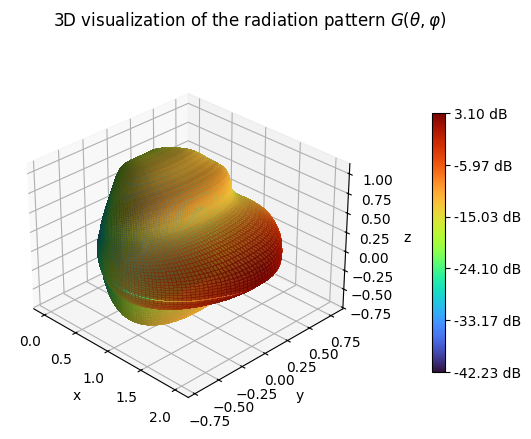

In [189]:
path = '80010465_0791_x_co.msi'

# let us read the given .msi file
antenna_gain, horizontal_angles, horizontal_gains, vertical_angles, vertical_gains = msi_file_reader(path)

# since the .msi file contains atenuations rather than gains:
horizontal_gains = -horizontal_gains
vertical_gains = -vertical_gains

# let's apply the cross-weighted algorithm
cross_weighted_antenna_gains = cross_weighted_algorithm(horizontal_angles,
                                                        horizontal_gains,
                                                        vertical_angles,
                                                        vertical_gains)

G_w_theta_phi_MAT = scipy.io.loadmat('pat3D_pablo.mat')
pat3D_matlab = G_w_theta_phi_MAT["pat3D"]
pat3D_matlab = 10**(pat3D_matlab/10)

# let's plot the computed gain from above's function
antenna_3D_rad_pattern(cross_weighted_antenna_gains)

Let us now check the values otbained with the Cross-weighted algorithm both on Matlab and on Python

Now that we have reconstructed the 3D radiation pattern of an antenna given its `.msi` file, with the help of the cross-weighted algorithm, we will compare the gain results with the one obtained with Matlab

In [170]:
# let us now compare the gains output by the cross-weighted algorithm and the one obtained in Matlab
G_w_theta_phi_MAT = scipy.io.loadmat('pat3D_pablo.mat')
pat3D_matlab = G_w_theta_phi_MAT["pat3D"]

print(f'This is the content of the G_w_theta_phi_MAT variable: {pat3D_matlab}')
print(f"This is the type of G_w_theta_phi_MAT: {type(pat3D_matlab)}")
print(f"This is the shape of G_w_theta_phi_MAT: {np.shape(pat3D_matlab)}")

# let's take the computed gain
print(f'This is the content of the cross_weighted_antenna_gains variable: {cross_weighted_antenna_gains}')
print(f"This is the type of cross_weighted_antenna_gains: {type(cross_weighted_antenna_gains)}")
print(f"This is the shape of cross_weighted_antenna_gains: {np.shape(cross_weighted_antenna_gains)}")


'''# let's load the .npy variable
G_w_theta_phi_npy = np.load('gain_theta_phi_dB_n_ROLANDO_ALEJANDRO.npy')
print(f'\nThis is the content of the G_w_theta_phi_npy variable: {G_w_theta_phi_npy}')
print(f"This is the shape of G_w_theta_phi_npy: {np.shape(G_w_theta_phi_npy)}")'''

'''# let us now compare them
if pat3D_matlab.all() == cross_weighted_antenna_gains.all():
    print(f'Both variables ARE THE SAME')
else:
    print(f"They are not the same")'''


This is the content of the G_w_theta_phi_MAT variable: [[3.07       3.09       3.1        ... 2.86       2.95       3.02      ]
 [3.07       3.09       3.1        ... 2.86       2.95       3.02      ]
 [3.06837723 3.08585786 3.09       ... 2.8597919  2.94966712 3.01937746]
 ...
 [3.05000001 3.05876896 3.06       ... 2.85669118 2.94475902 3.01055743]
 [3.05757359 3.06837723 3.07       ... 2.85813332 2.94702995 3.01456012]
 [3.06837723 3.08585786 3.09       ... 2.8597919  2.94966712 3.01937746]]
This is the type of G_w_theta_phi_MAT: <class 'numpy.ndarray'>
This is the shape of G_w_theta_phi_MAT: (360, 181)
This is the content of the cross_weighted_antenna_gains variable: [[2.02768272 2.03704208 2.04173794 ... 1.93196832 1.97242274 2.00447203]
 [2.02768272 2.03704208 2.04173794 ... 1.93196832 1.97242274 2.00447203]
 [2.02622355 2.03403925 2.03704208 ... 1.93178825 1.97212625 2.003907  ]
 ...
 [2.01503543 2.0219024  2.02301918 ... 1.92912714 1.96783875 1.9963857 ]
 [2.01872884 2.02622355 

'# let us now compare them\nif pat3D_matlab.all() == cross_weighted_antenna_gains.all():\n    print(f\'Both variables ARE THE SAME\')\nelse:\n    print(f"They are not the same")'

In [171]:
3.09-2.03704208

1.0529579199999999